In [12]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
from torch.distributions import Independent, Normal
from torchmetrics import StructuralSimilarityIndexMeasure as ssim
import torch.nn.functional as F
from torchvision.utils import save_image
PRINT_REQ= False

device = 'cuda' if torch.cuda.is_available() else 'cpu'


BATCH_SIZE=64
EPOCHS=50

cond_shape=10


torch.manual_seed(42)


In [13]:
# batch_size = 128
device="cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.MNIST(root="../data", train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(root="../data", train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=4)

flat_img=torch.flatten(train_data[0][0])
flat_shape=list(flat_img.shape)
flat_shape[0]

784

In [14]:
def print_debug(data):
    if PRINT_REQ:
        print(data)
    else:
        pass

In [15]:
class Encoder(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):

        super().__init__()
         # Encoder layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1,padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1,padding='same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2,padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=7, stride=1,padding='valid')
        self.lin1 = nn.Linear(in_features=90, out_features=20)
        self.lin2 = nn.Linear(in_features=90, out_features=20)

        # reparameterization
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, inputs):
        x = inputs[0].to(device)#.unsqueeze(dim=0)
        y = inputs[1].to(device)
        print_debug(f"img shape: {x.shape}, labels shape: {y.shape}")
        x = F.relu(self.conv1(x))
        print_debug(x.shape)
        # 32, 28, 28
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 32, 31, 31
        x = F.relu(self.conv2(x))
        print_debug(x.shape)
        # 32, 14, 14
        x = F.relu(self.conv3(x))
        print_debug(x.shape)
        # 64, 14, 14
        x = F.pad(x, (0,3,0,3))
        print_debug(x.shape)
        # 64, 17, 17
        x = F.relu(self.conv4(x))
        print_debug(x.shape)
        # 64, 7, 7
        x = F.relu(self.conv5(x))
        print_debug(x.shape)
        # 80, 1, 1
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        # 80
        print_debug(f"Concatenating {x.shape} with {y.shape}")
        concat = torch.cat([x, y], dim=-1)
        print_debug(f"After concatenation shape: {concat.shape}")
        # 90
        # loc=torch.zeros(mu_logvar.shape)
        # scale=torch.ones(mu_logvar.shape)
        # diagn = Independent(Normal(loc, scale), 1)
        mu = self.lin1(concat)
        print_debug(f"mu shape: {mu.shape}")
        # 20
        logvar = self.lin2(concat)
        print_debug(f"logvar shape: {logvar.shape}")
        z = self.reparameterize(mu, logvar)
        print_debug(f"Returning shape {z.shape}")
        return  mu, logvar, z

In [16]:
class Decoder(nn.Module):
    def __init__(self, dim_y, dim_z):
        super().__init__()
        self.dim_z = dim_z
        self.dim_y = dim_y
        self.deconv1 = nn.ConvTranspose2d(in_channels=30, out_channels=64, kernel_size=7, stride=1, padding=0) # valid means no pad
        self.deconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=2, padding=2, output_padding=1) # pad operation added in forward
        self.deconv6 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1,padding='same')
        

    def forward(self, inputs):
        x = inputs[0].to(device)#.unsqueeze(dim=0)
        y = inputs[1].to(device)
        print_debug(f"latent space shape: {x.shape}, labels shape: {y.shape}")
        x = torch.cat([x, y], dim=1)
        x = torch.reshape(x, (-1, self.dim_z+self.dim_y, 1, 1))
        print_debug(f"After concatenation shape: {x.shape}")
        x = F.relu(self.deconv1(x))
        print_debug(f"ConvTrans1 output shape: {x.shape}")
        x = F.relu(self.deconv2(x))
        print_debug(f"ConvTrans2 output shape: {x.shape}")
        x = F.pad(x, (0,0,0,0))
        x = F.relu(self.deconv3(x))
        print_debug(f"ConvTrans3 output shape: {x.shape}")
        x = F.relu(self.deconv4(x))
        print_debug(f"ConvTrans4 output shape: {x.shape}")
        # x = F.pad(x, (0,3,0,3))
        x = F.relu(self.deconv5(x))
        print_debug(f"ConvTrans5 output shape: {x.shape}")
        x = F.relu(self.deconv6(x))
        print_debug(f"ConvTrans6 output shape: {x.shape}")
        x = torch.sigmoid(self.conv(x))
        print_debug(f"Conv output shape: {x.shape}")
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        print_debug(f"After flatten shape: {x.shape}")
        return x

In [17]:
class CVAE(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):
        super().__init__()

        #Encoder 
        self.encoder = Encoder(dim_x=dim_x, dim_y=dim_y, dim_z=dim_z)

        #Decoder
        self.decoder = Decoder(dim_y=dim_y, dim_z=dim_z)

    def forward(self, inputs):
        x, y = inputs      
        y = F.one_hot(y, 10)  
        print_debug(f"Inputs shape: {x.shape} and labels: {y.shape}")
        mu, logvar, z = self.encoder((x,y))
        out = self.decoder((z, y))
        print_debug(f"decoder output shape is: {out.shape}")
        return mu, logvar, out


   


In [18]:
model = CVAE(dim_x=(28, 28, 1), dim_y=10, dim_z=20).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def loss_fn(recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon, x, reduction='sum')        
    KLD = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    return BCE+KLD

In [19]:
# one iteration to validate output shapes with PRINT_DEBUG = True
for i, (x, y) in enumerate(train_dataloader):    
    model((x,y))
    break 

In [20]:
def train(epoch):
    
    model.train()
    train_loss = 0


    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device) #[64, 1, 28, 28]
        
        
        
        # 1. Forward pass
        mu, logvar, recon_batch = model((X, y))
        
        flat_data = X.view(-1, flat_shape[0]).to(device)                            
        y_onehot = F.one_hot(y, cond_shape).to(device)
        inp = torch.cat((flat_data, y_onehot), 1)
        
        # 2. Calculate loss
        loss = loss_fn(recon_batch, flat_data, mu, logvar)
        train_loss += loss.item()

        # 3. Zero grad
        optimizer.zero_grad()

        # 4. Backprop
        loss.backward()

        # 5. Step
        optimizer.step()

        if batch % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch * len(X),
                len(train_dataloader.dataset),
                100. * batch / len(train_dataloader),
                loss.item() / len(X)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_dataloader.dataset)))

In [21]:
def test(epoch):
    #Sets the module in evaluation mode
    model.eval()
    test_loss = 0

    with torch.inference_mode():
        for i, (X, y) in enumerate(test_dataloader):
            X = X.to(device)

            # 1. Forward pass
            mu, logvar, recon_batch = model((X, y))
            
            flat_data = X.view(-1, flat_shape[0]).to(device)
            y_onehot = F.one_hot(y, cond_shape).to(device)
            inp = torch.cat((flat_data, y_onehot), 1)

            # 2. Loss
            test_loss += loss_fn(recon_batch, flat_data, mu, logvar).item()

            # 3. Save images
            if epoch%5==0 and i == 0:
                n = min(X.size(0), 8)
                recon_image = recon_batch[:, 0:recon_batch.shape[1]]
                print(recon_image.shape)
                recon_image = recon_image.view(BATCH_SIZE, 1, 28,28)
                print('---',recon_image.shape)
                comparison = torch.cat([X[:n],
                                      recon_image.view(BATCH_SIZE, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))




In [22]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # Generate random digits every n epochs
    with torch.inference_mode():
        if epoch%5==0:
            sample = torch.randn(64, 20).to(device)
        
            c = np.zeros(shape=(sample.shape[0],))
            rand = np.random.randint(0, 10)
            print(f"Random number: {rand}")
            c[:] = rand
            c = torch.FloatTensor(c)
            c = c.to(torch.int64)
            c = c.to(device)
            c = F.one_hot(c, cond_shape)
            sample = model.decoder((sample, c)).cpu()
            
            generated_image = sample[:, 0:sample.shape[1]]
            
            
            save_image(generated_image.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')


Train Epoch: 1 [0/60000 (0%)]	Loss: 548.480530
Train Epoch: 1 [640/60000 (1%)]	Loss: 548.043152
Train Epoch: 1 [1280/60000 (2%)]	Loss: 547.865601
Train Epoch: 1 [1920/60000 (3%)]	Loss: 547.258301
Train Epoch: 1 [2560/60000 (4%)]	Loss: 546.815979
Train Epoch: 1 [3200/60000 (5%)]	Loss: 546.460632
Train Epoch: 1 [3840/60000 (6%)]	Loss: 546.058533
Train Epoch: 1 [4480/60000 (7%)]	Loss: 545.587097
Train Epoch: 1 [5120/60000 (9%)]	Loss: 545.089111
Train Epoch: 1 [5760/60000 (10%)]	Loss: 544.545715
Train Epoch: 1 [6400/60000 (11%)]	Loss: 543.924255
Train Epoch: 1 [7040/60000 (12%)]	Loss: 543.150879
Train Epoch: 1 [7680/60000 (13%)]	Loss: 542.258118
Train Epoch: 1 [8320/60000 (14%)]	Loss: 540.975220
Train Epoch: 1 [8960/60000 (15%)]	Loss: 539.329285
Train Epoch: 1 [9600/60000 (16%)]	Loss: 536.879028
Train Epoch: 1 [10240/60000 (17%)]	Loss: 531.998291
Train Epoch: 1 [10880/60000 (18%)]	Loss: 524.047852
Train Epoch: 1 [11520/60000 (19%)]	Loss: 510.672760
Train Epoch: 1 [12160/60000 (20%)]	Loss: 

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


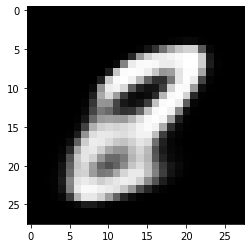

In [31]:
model.eval()
with torch.inference_mode():
    z = torch.randn(1, 20).cuda()
    c = torch.eye(10).cuda()
    lbl = c[2].unsqueeze(dim=0)
    lbl = lbl.to(torch.int64)
    print(lbl)
    sample = model.decoder((z, lbl))
sample=sample.cpu()
sample=sample.reshape([1,1,28,28])
plt.imshow(sample[0].squeeze().cpu(), cmap="gray")